In [ ]:
# %% Imports & global setup ---------------------------------------------------
import json, warnings
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt

import mne
from mne.decoding import (
    Scaler, Vectorizer, LinearModel, SlidingEstimator, cross_val_multiscore, get_coef
)
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import StratifiedGroupKFold, GroupKFold

from pyddeeg import EEG_CHANNELS, RQA_METRICS

# ---------- Dataset parameters ---------------------------------------------
DATASET_ROOT = Path("/home/mario/Python/Datasets/EEG/timeseries/processed/rqa_windows/dataset")
WINDOW       = "window_200"   # 200‑ms window length
DIRECTION    = "up"

meta = np.load(DATASET_ROOT / WINDOW / "metadata.npz")
centres_ms = meta["centers"].astype(int)   # e.g. [100, 200, …] length 679
STRIDE_MS  = int(meta["stride"])           # 100 ms
WINDOW_MS  = int(WINDOW.split("_")[-1])    # 200 ms
TOTAL_MS   = centres_ms[-1] + WINDOW_MS//2  # expected 68 000 ms
SFREQ      = 1000 / STRIDE_MS

routes = json.loads((DATASET_ROOT / "dataset_index.json").read_text())[WINDOW][DIRECTION]

# CV splitter ---------------------------------------------------------------
try:
    CV = StratifiedGroupKFold(n_splits=5)
    CV_NAME = "StratifiedGroupKFold"
except ImportError:
    CV = GroupKFold(n_splits=5)
    CV_NAME = "GroupKFold"
    
from pyddeeg.classification.dataloaders import EEGDataset
from pyddeeg.classification.engine import trainer

dataset = EEGDataset.load(dataset_root=DATASET_ROOT, window=WINDOW, direction=DIRECTION, random_state=42)
elec="T7"
results = trainer.compute_auc_per_electrode(elec=elec, 
                                  dataset=dataset, 
                                  model=LinearModel(LogisticRegression(max_iter=1000)))
np.savez(DATASET_ROOT / WINDOW / f"results_{DIRECTION}_{elec}.npz",
         results=results, 
         dataset=dataset)

Not setting metadata
49 matching events found
No baseline correction applied
0 projection items activated


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.

  0%|          | Fitting SlidingEstimator : 0/679 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/679 [00:00<?,       ?it/s]
  0%|          | Fitting SlidingEstimator : 1/679 [00:00<00:51,   13.13it/s]


  1%|          | Fitting SlidingEstimator : 4/679 [00:00<00:13,   49.77it/s]


  0%|          | Fitting SlidingEstimator : 0/679 [00:00<?,       ?it/s]
  0%|          | Fitting SlidingEstimator : 0/679 [00:00<?,       ?it/s]t/s]

  1%|          | Fitting SlidingEstimator : 8/679 [00:00<00:12,   52.49it/s]
  1%|▏         | Fitting SlidingEstimator : 9/679 [00:00<00:16,   41.39it/s]




  0%|          | Fitting SlidingEstimator : 2/679 [00:00<00:38,   17.54it/s]][A
  2%|▏         | Fitting SlidingEstimator : 12/679 [00:00<00:15,   43.40it/s]








  1%|          | Fitting SlidingEstimator : 6/679 [00:00<00:17,   37.48it/s]][A
  2%|▏         | Fitting SlidingEstimator : 16/679 [00:00<00:13

In [ ]:
import numpy as np

object = np.load(DATASET_ROOT / WINDOW / f"results_{DIRECTION}.npz", allow_pickle=True)
results = object["results"].item()
dataset = object["dataset"].item()

NameError: name 'np' is not defined

(<Figure size 1400x1000 with 3 Axes>,
 (<Axes: title={'center': 'Classification performance and patterns for T7 electrode (ROC AUC)'}, ylabel='ROC AUC'>,
  <Axes: xlabel='Time (ms)', ylabel='RQA Metrics'>))

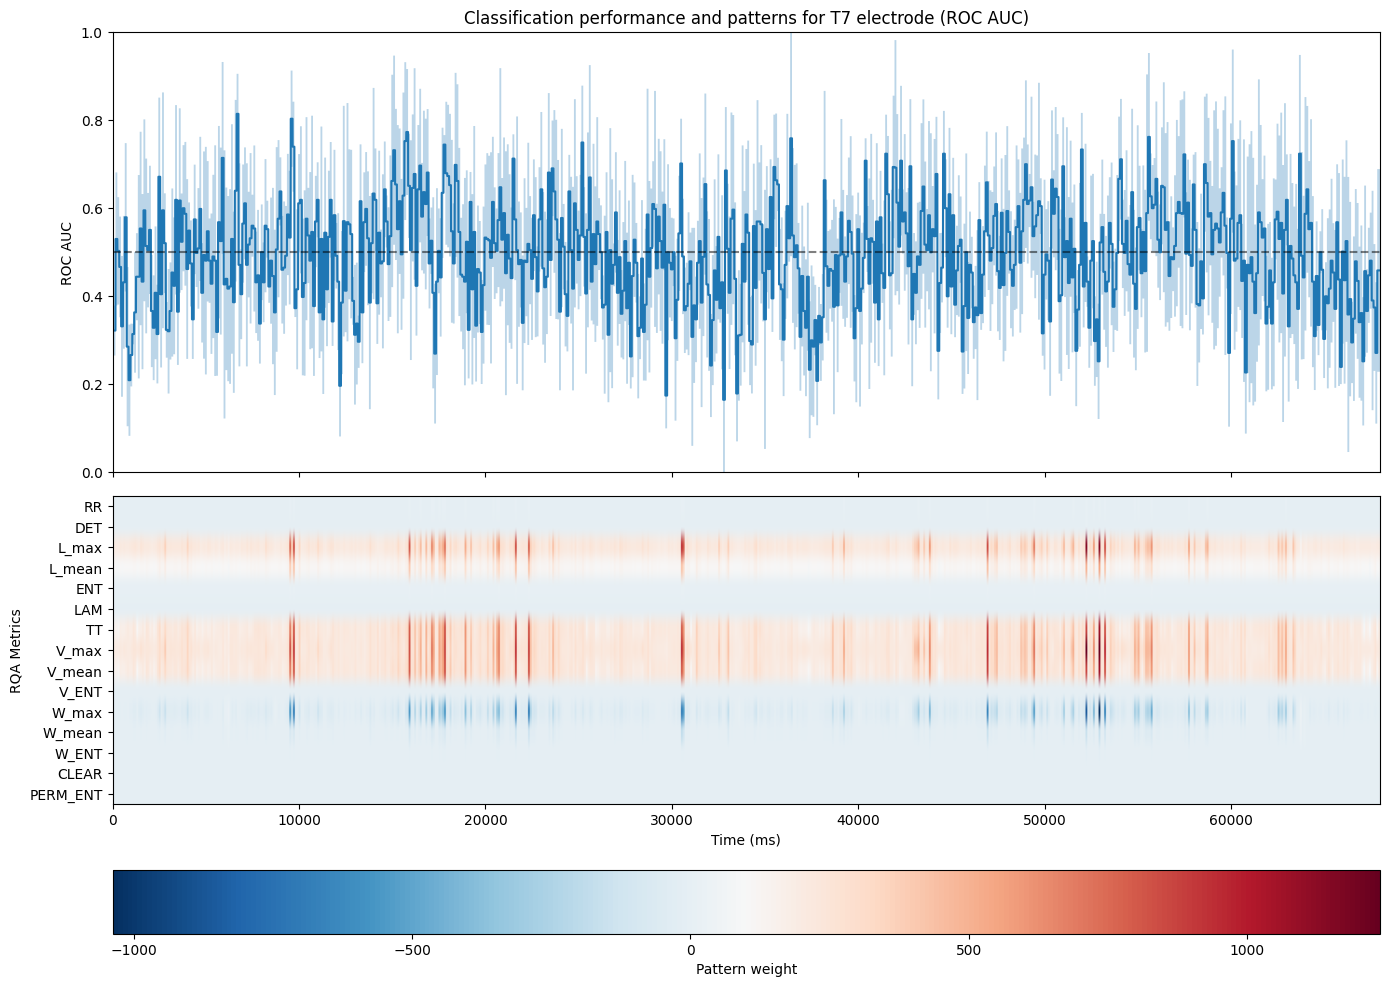

In [ ]:
from pyddeeg.classification.utils.basic_visualizations import plot_classification_results

# Basic usage with default styling
fig, axes = plot_classification_results(results, "Fz", dataset, metric="roc")

# Custom styling through keyword arguments
fig, axes = plot_classification_results(
    results, 
    "Fz", 
    dataset, 
    metric="roc",
    time_in_ms=True,
    # Figure styling
    figsize=(16, 12),
    title="Custom ROC AUC Analysis",
    
    # Axes styling
    ylim=(0.4, 1.0),
    grid=True,
    
    # Component-specific styling
    performance_kwargs={
        "color": "darkblue",
        "linewidth": 2,
        "marker": "o",
        "markersize": 4
    },
    patterns_kwargs={
        "cmap": "viridis",
        "interpolation": "nearest"
    },
    colorbar_kwargs={
        "label": "Feature importance",
        "orientation": "vertical"
    }
)

plt.show()